# 03_SHAP (SHapley Additive exPlanations)
### [shap](https://github.com/slundberg/shap): A game theoretic approach to explain the output of any machine learning model.

<img src="slide_image/shap_header.svg" width=720/>

### 實作程式碼

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.size'] = 20.0
# plt.rcParams['figure.figsize'] = (10.0, 8.5)
sns.set(style='darkgrid') # style參數可以改變繪圖的風格，darkgrid代表背景是黑色並有畫出網格線

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df =  pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
X = df[['Pclass','SibSp','Parch','Fare']]
y = df['Survived'].values

In [7]:
! pip install shap
import xgboost
import sklearn
import shap
from sklearn.model_selection import train_test_split

#  Tree SHAP to explain  predictions

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
classifier = xgboost.XGBClassifier().fit(X_train, y_train)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_train)

#### 單一資料解釋

第一筆資料有 0.51 預測為 Survived = 1

In [9]:
X_train[:1]

,Pclass,SibSp,Parch,Fare
140,3,0,2,15.2458


In [10]:
classifier.predict_proba(X_train[:1])

array([[0.48609185, 0.51390815]], dtype=float32)

紅色代表正的貢獻度、藍色代表負的貢獻度
- 正面的影響：
  - Parch: +0.79
  - Fare: +0.17
  - Sibsp: +0.04
- 負面的影響：
  - Pclass: -0.44
  

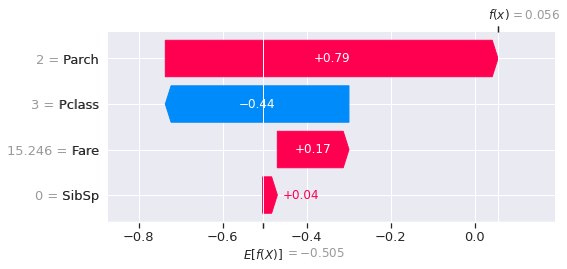

In [11]:
# waterfall
shap.plots.waterfall(shap_values[0])

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_train.iloc[0,:])

#### 整體資料解釋

##### summary plot

- 點的顏色: Feature value 的大小，越紅越高、越藍越低；
- X 軸： shape value 的範圍

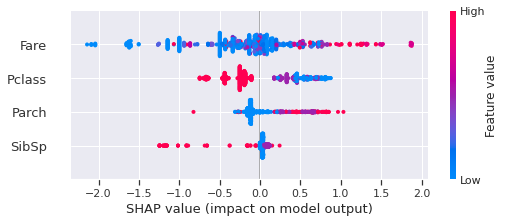

In [13]:
shap.summary_plot(shap_values, X_train)

- Pclass 對於分類很有幫助
- Fare越小對於預測值的貢獻度越低

In [14]:
# 切第 0~4 筆資料查看
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:],X.iloc[0:5,:], plot_cmap="DrDb")

In [15]:
# 看整體資料
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values, X_train, plot_cmap="DrDb")

#### 其他圖參考

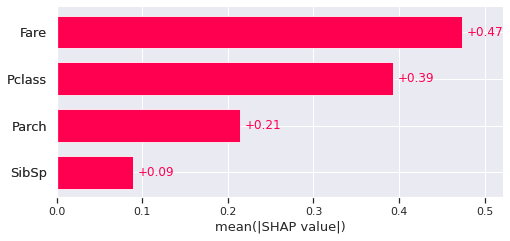

In [16]:
shap.plots.bar(shap_values)

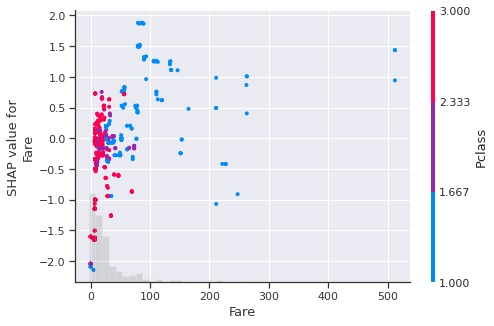

In [17]:
shap.plots.scatter(shap_values[:, "Fare"], color=shap_values[:,"Pclass"])

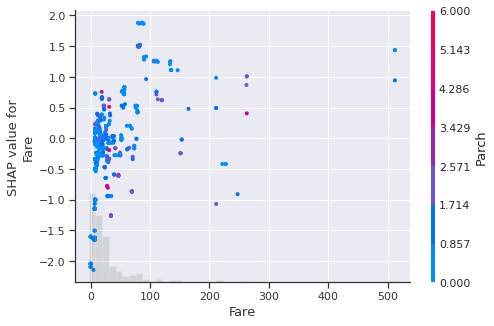

In [18]:
shap.plots.scatter(shap_values[:, "Fare"], color=shap_values[:,"Parch"])

#  Kernel SHAP to explain  predictions

In [19]:
import sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [20]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model=svm.predict_proba, data=X_train, link="logit")
shap_values = explainer.shap_values(X=X_test, nsamples=10, l1_reg="num_features(4)")

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/179 [00:00<?, ?it/s]

In [21]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 2
Shape of each element: (179, 4)


In [22]:
# plot the SHAP values for  output of the first instance
print(f'Prediction for 1st sample in X_test: {svm.predict_proba(X_test.iloc[[0], :])[0]}')
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Prediction for 1st sample in X_test: [0.66874073 0.33125927]


In [23]:
# plot the SHAP values for output of the first instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:], link="logit")

In [24]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

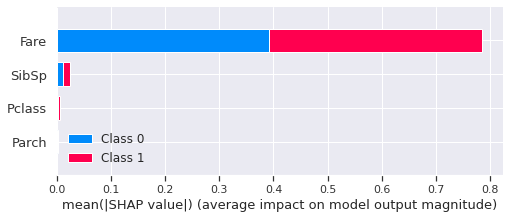

In [95]:
shap.summary_plot(shap_values, X_test)

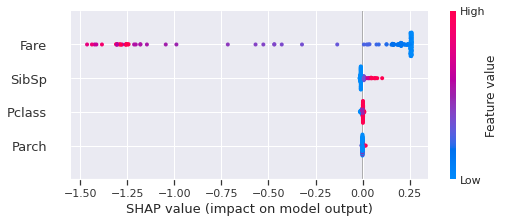

In [96]:
shap.summary_plot(shap_values[0], X_test)

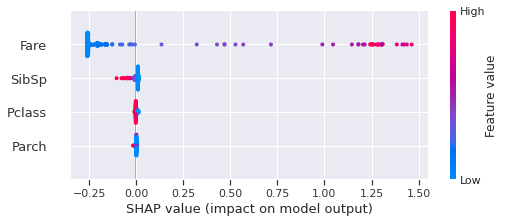

In [97]:
shap.summary_plot(shap_values[1], X_test)